# Hi everyone!

Analyzing data and identifying certain patterns is something that can also be applied to understand certain behaviors and " categories " of people, and that's what we'll see today ! For this, we will use this dataset available here : 

https://www.kaggle.com/datasets/vetrirah/customer

# Dataset Presentation

#### Context : 
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market. 

#### Columns Description : 

ID : Customer's ID.

Gender : Customer's Gender (Male/Female)

Ever_Married : Marrital Statue of the Customer (Yes/No)

Age : Customer's Age

Graduated : If the Customer is Graduated or No (Yes/No)

Work_Experience : Customer's Work Experience in Years

Spending Score : Spending Score of the Customer (Low,Average,High)

Var_1 : Anonymised Category for the customer. ('Cat_1','Cat_2',..,'Cat_6') (WE WILL NOT FOCUS ON THIS)

Segmentation : Category of the Customer (WE WILL NOT FOCUS ON THIS)

#### Dataset Preview

In [117]:
# Import convention
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
pd.read_csv('customers.csv').head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


#### Our Goal

The dataset was originally given for a competition where they had to make a model to PREDICT the customers segments with a Train.csv and a Test.csv files, but since we want to detect the categories by ourselves, we will not use the "Segmentation" column !

# Let's Start !

## Importing Libraries & General Overview

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#To not display certain errors
import warnings
warnings.filterwarnings('ignore')

In [120]:
df=pd.read_csv('customers.csv')
df=df.drop(['Var_1'],axis=1) #Let's remove the unnecessary columns first 
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0
...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0


#### Checking if there is Null values + Columns Values

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 184.8+ KB


In [122]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


It looks like there are some Null values in our data, but at least our numerical values look consistent and in the right ranges.

#### Adding new Columns

For the purpose of our analysis, we will categorize our "Age" field into a new column by making some ranges.

In [123]:
df['AgeCat']=pd.cut(df['Age'],bins=[0, 18, 25, 35,46, 100], labels=['0-18', '19-25', '26-35', '36-46','47+'])
df.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,AgeCat
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,36-46
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,36-46
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,47+


## Data Cleaning (We'll check each field and their missing values.)

### Usefull Functions

In [124]:
def null_values(field):
    return df[field].isnull().sum()
print("Missing Values :")
for i in df.columns:
    print(i+' : ',null_values(i))

Missing Values :
ID :  0
Gender :  0
Ever_Married :  50
Age :  0
Graduated :  24
Profession :  38
Work_Experience :  269
Spending_Score :  0
Family_Size :  113
AgeCat :  0


In [125]:
def groupby_count(df, groupby_cols, count_col, filter_cols=None):
    if filter_cols:
        df = df[filter_cols + groupby_cols + [count_col]]
    else:
        df = df[groupby_cols + [count_col]]
    return df.groupby(by=groupby_cols).count()

### Ever_Married

In [126]:
print(groupby_count(df, ['Spending_Score','Ever_Married'], 'ID') )

                               ID
Spending_Score Ever_Married      
Average        Yes            610
High           Yes            375
Low            No            1057
               Yes            535


- All Average / High Spending_Score are Married

In [127]:
print(groupby_count(df, ['Profession','Ever_Married'], 'ID') )

                             ID
Profession    Ever_Married     
Artist        No            251
              Yes           542
Doctor        No            113
              Yes           124
Engineer      No             85
              Yes           143
Entertainment No            109
              Yes           187
Executive     No              9
              Yes           163
Healthcare    No            362
              Yes            47
Homemaker     No             35
              Yes            44
Lawyer        No             14
              Yes           204
Marketing     No             66
              Yes            43


- People with Healthcare profession are mostly not married

In [128]:
print(groupby_count(df, ['AgeCat','Ever_Married'], 'ID') )

                      ID
AgeCat Ever_Married     
0-18   No             39
       Yes             2
19-25  No            255
       Yes            23
26-35  No            436
       Yes           164
36-46  No            239
       Yes           459
47+    No             88
       Yes           872


- 47+ People are mostly married
- 19-25 People are mostly not married
- 26-35 People are mostly not married

In [129]:
x=df.query("Spending_Score == 'High' and Ever_Married.isna()").index
x

Int64Index([261, 379, 400, 448, 1090, 1489, 1532, 1717, 1736, 1741, 1878], dtype='int64')

In [130]:
x=df.query("Spending_Score == 'High' and Ever_Married.isna()")
x

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,AgeCat
261,459821,Male,NaN,71,No,Executive,NaN,High,1.0,47+
379,460222,Female,NaN,73,Yes,Lawyer,4.0,High,NaN,47+
400,460305,Female,NaN,49,Yes,Entertainment,0.0,High,1.0,47+
448,460434,Male,NaN,57,Yes,Artist,2.0,High,3.0,47+
1090,462619,Male,NaN,58,No,NaN,1.0,High,NaN,47+
1489,464016,Female,NaN,29,Yes,Entertainment,1.0,High,1.0,26-35
1532,464169,Male,NaN,83,No,Lawyer,0.0,High,2.0,47+
1717,464836,Female,NaN,32,No,Engineer,7.0,High,5.0,26-35
1736,464905,Male,NaN,81,No,Executive,NaN,High,2.0,47+
1741,464916,Female,NaN,32,NaN,Doctor,8.0,High,2.0,26-35


In [131]:
x=df.query("Spending_Score == 'High' and Ever_Married.isna()")
x['Ever_Married']='Yes'
df.update(x)

x=df.query("Profession == 'Healthcare' and Ever_Married.isna()")
x['Ever_Married']='No'
df.update(x)

x=df.query("AgeCat == '47+' and Ever_Married.isna()")
x['Ever_Married']='Yes'
df.update(x)

x=df.query("AgeCat == '19-25' and Ever_Married.isna()")
x['Ever_Married']='No'
df.update(x)

x=df.query("AgeCat == '26-35' and Ever_Married.isna()")
x['Ever_Married']='No'
df.update(x)

In [132]:
print(null_values("Ever_Married")," We're not done yet !")

9  We're not done yet !


#### We have to check the 36-46 range now

In [133]:
df.query("Ever_Married.isna()")['AgeCat'].unique()

array(['36-46'], dtype=object)

In [134]:
print(groupby_count(df.query("AgeCat=='36-46'"), ['AgeCat','Profession','Ever_Married'], 'ID'))

                                    ID
AgeCat Profession    Ever_Married     
36-46  Artist        No            119
                     Yes           186
       Doctor        No             16
                     Yes            37
       Engineer      No             27
                     Yes            61
       Entertainment No             39
                     Yes            78
       Executive     No              2
                     Yes            48
       Healthcare    No             14
                     Yes            16
       Homemaker     No              3
                     Yes            15
       Lawyer        No              1
                     Yes             1
       Marketing     No             14
                     Yes            11


- For people in 36-46, they're mostly married, apart for those in the Marketing field

In [135]:
x=df.query("AgeCat=='36-46' and Ever_Married.isna() and Profession != 'Marketing'")
y=df.query("AgeCat=='36-46' and Ever_Married.isna() and Profession == 'Marketing'")

x['Ever_Married']='Yes'
y['Ever_Married']='No'

df.update(x)
df.update(y)

print(null_values('Ever_Married')," (Let's go !) ")

0  (Let's go !) 


### Graduated

In [136]:
print(null_values('Graduated'))

24


In [137]:
print(groupby_count(df, ['AgeCat','Graduated'], 'ID') )

                   ID
AgeCat Graduated     
0-18   No          40
       Yes          1
19-25  No         246
       Yes         36
26-35  No         270
       Yes        338
36-46  No         167
       Yes        536
47+    No         278
       Yes        691


- 0-18 People Are mostly not graduated
- 19-25 People are mostly not graduated
- 47+ People are mostly graduated

In [138]:
print(groupby_count(df, ['Profession','Graduated'], 'ID') )

                          ID
Profession    Graduated     
Artist        No          94
              Yes        701
Doctor        No          90
              Yes        151
Engineer      No         124
              Yes        112
Entertainment No         115
              Yes        182
Executive     No          86
              Yes         89
Healthcare    No         275
              Yes        139
Homemaker     No          38
              Yes         44
Lawyer        No          92
              Yes        124
Marketing     No          69
              Yes         41


- Most Artist are graduated

In [139]:
print(groupby_count(df, ['Ever_Married','Graduated'], 'ID') )

                          ID
Ever_Married Graduated      
No           No          537
             Yes         528
Yes          No          464
             Yes        1074


- There is more chance that married people are Graduated

In [140]:
x=df.query("(AgeCat=='0-18' or AgeCat=='19-25') and Graduated.isna()")
x['Graduated']='No'
df.update(x)

x=df.query("Profession=='Artist' and Graduated.isna()")
x['Graduated']='Yes'
df.update(x)

x=df.query("(AgeCat=='47+') and Graduated.isna()")
x['Graduated']='Yes'
df.update(x)

x=df.query("Ever_Married=='Yes' and Graduated.isna()")
x['Graduated']='Yes'
df.update(x)

In [141]:
print(null_values('Graduated')," Let's drop the rest !")

1  Let's drop the rest !


In [142]:
df=df.drop(df.query("Graduated.isna()").index)

### Profession

In [143]:
null_values("Profession")

38

<AxesSubplot: xlabel='Profession', ylabel='count'>

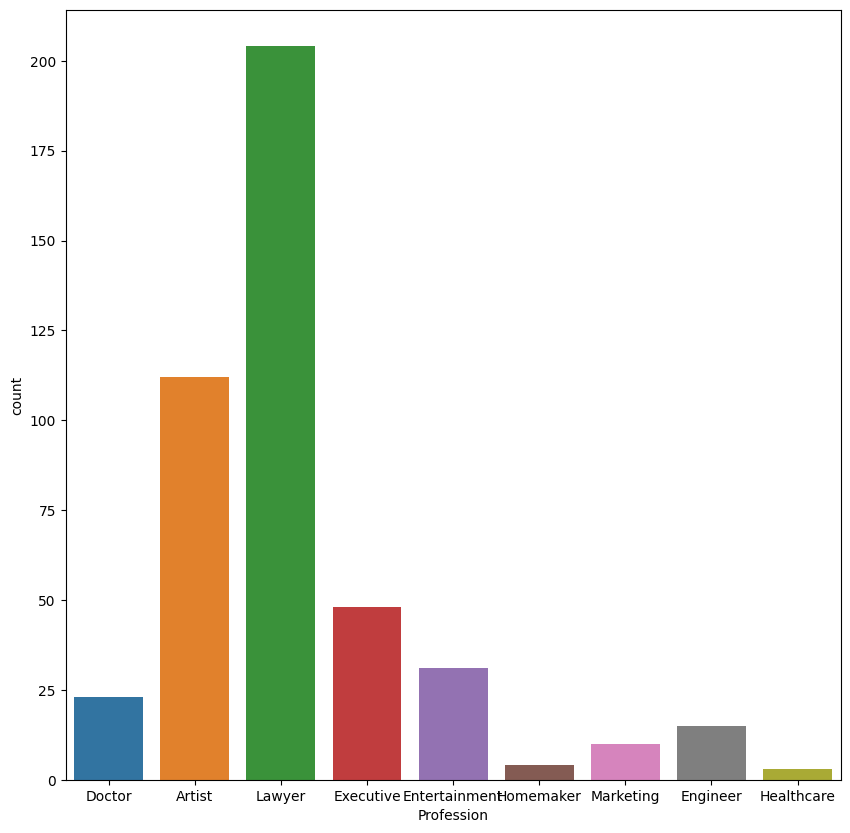

In [144]:
x=df.query("Age>60")
plt.figure(figsize=(10,10))
sns.countplot(x[["Profession"]],x="Profession")

In [145]:
print(groupby_count(x, ['Spending_Score','Profession'], 'ID') )

                               ID
Spending_Score Profession        
Average        Artist          45
               Doctor          12
               Engineer         2
               Entertainment   14
               Executive        4
               Healthcare       1
               Lawyer           5
               Marketing        2
High           Artist          28
               Doctor           2
               Engineer         2
               Entertainment    4
               Executive       31
               Healthcare       1
               Homemaker        1
               Lawyer         112
               Marketing        4
Low            Artist          39
               Doctor           9
               Engineer        11
               Entertainment   13
               Executive       13
               Healthcare       1
               Homemaker        3
               Lawyer          87
               Marketing        4


People that are 60+ years old : 
- Are mostly Artist if they have an average Spending_Score
- Are mostly Lawyers if they have a High/Low Spending_Score

In [146]:
x=df.query("Age>60 and Profession.isna() and Spending_Score=='Average'")
x['Profession']='Artist'
df.update(x)

x=df.query("Age>60 and Profession.isna() and (Spending_Score=='Low' or Spending_Score=='High')")
x['Profession']='Lawyer'
df.update(x)

In [147]:
x=df.query("Graduated=='Yes' and Profession.isna()")
x['Profession']='Artist'
df.update(x) ##Remember ! Most Artists are graduated

In [148]:
print(groupby_count(df, ['AgeCat','Profession'], 'ID') )

                       ID
AgeCat Profession        
0-18   Artist           1
       Doctor           5
       Engineer         3
       Entertainment    3
       Healthcare      27
       Marketing        3
19-25  Artist          13
       Doctor          27
       Engineer        12
       Entertainment   10
       Executive        3
       Healthcare     184
       Homemaker        9
       Lawyer           2
       Marketing       21
26-35  Artist         124
       Doctor          91
       Engineer        62
       Entertainment   75
       Executive       21
       Healthcare     169
       Homemaker       36
       Marketing       30
36-46  Artist         317
       Doctor          54
       Engineer        91
       Entertainment  117
       Executive       51
       Healthcare      30
       Homemaker       18
       Lawyer           2
       Marketing       25
47+    Artist         366
       Doctor          65
       Engineer        68
       Entertainment   95
       Execu

In [149]:
x=df.query("(AgeCat=='0-18' or AgeCat=='19-25') and Profession.isna()")
x['Profession']='Healthcare'
df.update(x) 

x=df.query("Age>47 and Age<60 and Profession.isna()")
x['Profession']="Artist"
df.update(x)

In [150]:
print(groupby_count(df, ['Ever_Married','Profession'], 'ID') )

                             ID
Ever_Married Profession        
No           Artist         257
             Doctor         116
             Engineer        85
             Entertainment  109
             Executive        9
             Healthcare     375
             Homemaker       37
             Lawyer          14
             Marketing       67
Yes          Artist         569
             Doctor         126
             Engineer       151
             Entertainment  191
             Executive      167
             Healthcare      47
             Homemaker       45
             Lawyer         210
             Marketing       44


- Not Married People have a Healthcare profession
- Married People are Artists ! (Again)

In [151]:
x=df.query("Ever_Married=='Yes' and Profession.isna()")
x['Profession']="Artist"
df.update(x)

x=df.query("Ever_Married=='No' and Profession.isna()")
x['Profession']="Healthcare"
df.update(x)

### Work_Experience

In [152]:
null_values("Work_Experience")

269

In [153]:
df['Work_Experience'].describe(percentiles=[i*0.1 for i in range(10)])

count    2357.000000
mean        2.551124
std         3.341048
min         0.000000
0%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         1.000000
50%         1.000000
60%         1.000000
70%         3.000000
80%         6.000000
90%         8.000000
max        14.000000
Name: Work_Experience, dtype: float64

In [154]:
df['Work_Experience'] = df['Work_Experience'].fillna(method='pad')


In [155]:
df['Work_Experience'].describe(percentiles=[i*0.1 for i in range(10)])

count    2626.000000
mean        2.589490
std         3.362395
min         0.000000
0%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         1.000000
50%         1.000000
60%         1.000000
70%         3.000000
80%         6.000000
90%         8.000000
max        14.000000
Name: Work_Experience, dtype: float64

#### There weren't too many changes after using the "Pad" filling method, so it works and we can continue!

### Family_Size

In [156]:
null_values("Family_Size")

113

In [157]:
df['Family_Size'].describe(percentiles=[i*0.1 for i in range(10)])

count    2513.000000
mean        2.826104
std         1.551787
min         1.000000
0%          1.000000
10%         1.000000
20%         1.000000
30%         2.000000
40%         2.000000
50%         2.000000
60%         3.000000
70%         4.000000
80%         4.000000
90%         5.000000
max         9.000000
Name: Family_Size, dtype: float64

In [158]:
df['Family_Size'] = df['Family_Size'].fillna(method='pad')


In [159]:
df['Family_Size'].describe(percentiles=[i*0.1 for i in range(10)])

count    2626.000000
mean        2.833206
std         1.571041
min         1.000000
0%          1.000000
10%         1.000000
20%         1.000000
30%         2.000000
40%         2.000000
50%         2.000000
60%         3.000000
70%         4.000000
80%         4.000000
90%         5.000000
max         9.000000
Name: Family_Size, dtype: float64

## Here we go ! 
## Next Step : Preprocessing

We will encode our discrete fields for our machine learning model so things like : 
- (Yes/No) will become (1/0)

Also we will drop "ID" column since it doesn't bring any usefull information, same for the "AgeCat" field.

In [160]:
original_df=df
df=df.drop(labels=['ID','AgeCat'],axis=1)
L=list(df['Profession'].unique())


df['Profession']=df['Profession'].apply(lambda x:L.index(x)+1 )


df['Ever_Married']=df['Ever_Married'].replace(('Yes','No'),(1,0))
df['Graduated']=df['Graduated'].replace(('Yes','No'),(1,0))
df['Gender']=df['Gender'].replace(('Male','Female'),(1,0))


L=list(df['Spending_Score'].unique())
df['Spending_Score']=df['Spending_Score'].apply(lambda x:L.index(x)+1 )

df.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,1,36.0,1,1,0.0,1,1.0
1,1,1,37.0,1,2,8.0,2,4.0
2,0,1,69.0,0,3,0.0,1,1.0
3,1,1,59.0,0,4,11.0,3,2.0
4,0,0,19.0,0,5,11.0,1,4.0


## Next Step : Clustering

### What's a Clustering Model ?


A clustering model is a type of unsupervised machine learning algorithm that groups data points into clusters based on their similarity. 

Clustering models are used to identify patterns and group similar data points together. Clustering can be used for a variety of tasks, such as segmenting customers into different groups, identifying outliers, and finding relationships between variables.

### Which model will we use ? 

Since our dataset is a mix between numerical and categorical columns..

Just as a reminder : 
- A numerical variable is a type of data that is represented by numbers. Examples of numerical variables include age, height, weight, and income.

- A categorical variable is a type of data that is represented by categories or labels. Examples of categorical variables include gender, race, religion, and marital status.

A Clustering model that can handle both of these is K-Prototypes

#### Example here with a Clustering model for numerical values (K-MEANS) : 

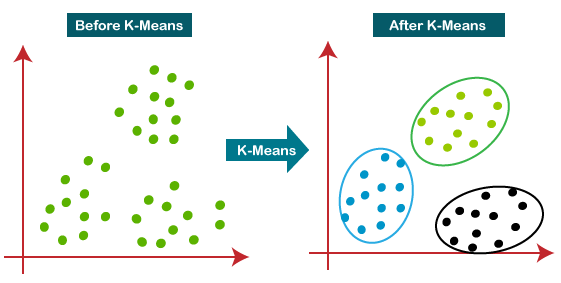


### K-Prototypes

K-Prototypes is a clustering algorithm that combines the features of both K-Means (Numerical Values) and K-Modes (Categorical Values) algorithms.

It works by assigning each data point to a cluster based on its similarity to the cluster's prototype, which is a combination of the mean of the numerical variables and the mode of the categorical variables. This allows it to identify clusters in datasets with mixed types of data, making it a powerful tool for exploratory data analysis.

For this, we will be using the kmodes library.

## Let's get started ! 

In [161]:
from kmodes.kprototypes import KPrototypes

In [162]:
df.head(2)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,1,36.0,1,1,0.0,1,1.0
1,1,1,37.0,1,2,8.0,2,4.0


In [163]:
categorical_features_idx=[0,1,3,4,5,6] #Categorical columns of our dataset
mark_array=df.values

In [164]:
pd.DataFrame(mark_array, columns=df.columns)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0.0,1.0,36.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,37.0,1.0,2.0,8.0,2.0,4.0
2,0.0,1.0,69.0,0.0,3.0,0.0,1.0,1.0
3,1.0,1.0,59.0,0.0,4.0,11.0,3.0,2.0
4,0.0,0.0,19.0,0.0,5.0,11.0,1.0,4.0
...,...,...,...,...,...,...,...,...
2621,1.0,0.0,29.0,0.0,2.0,9.0,1.0,4.0
2622,0.0,0.0,35.0,1.0,6.0,1.0,1.0,1.0
2623,0.0,0.0,53.0,1.0,8.0,1.0,1.0,2.0
2624,1.0,1.0,47.0,1.0,4.0,1.0,3.0,5.0


In [165]:
kproto = KPrototypes(n_clusters=4, verbose=2, max_iter=20).fit(mark_array, categorical=categorical_features_idx)


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 463, ncost: 117605.83667212076
Run: 1, iteration: 2/20, moves: 230, ncost: 109951.60214459707
Run: 1, iteration: 3/20, moves: 252, ncost: 103047.090975319
Run: 1, iteration: 4/20, moves: 143, ncost: 100720.69637378203
Run: 1, iteration: 5/20, moves: 65, ncost: 100282.24689220129
Run: 1, iteration: 6/20, moves: 83, ncost: 99672.86420477953
Run: 1, iteration: 7/20, moves: 56, ncost: 99332.85516049853
Run: 1, iteration: 8/20, moves: 38, ncost: 99201.00745548005
Run: 1, iteration: 9/20, moves: 13, ncost: 99186.43859970926
Run: 1, iteration: 10/20, moves: 12, ncost: 99160.25442781535
Run: 1, iteration: 11/20, moves: 6, ncost: 99132.08246510022
Run: 1, iteration: 12/20, moves: 9, ncost: 99100.73738897113
Run: 1, iteration: 13/20, moves: 6, ncost: 99089.84798615839
Run: 1, iteration: 14/20, moves: 2, ncost: 

### Cluster Analysis : Let's de-code the dataset values and try to understand it ! 

In [166]:
clusters = kproto.predict(mark_array, categorical=categorical_features_idx)
df['cluster'] = list(clusters)
df['Profession']=original_df['Profession']
df['Gender']=original_df['Gender']
df['Ever_Married']=original_df['Ever_Married']
df['Graduated']=original_df['Graduated']
df['Spending_Score']=original_df['Spending_Score']
df['ID']=original_df['ID']

In [181]:
np.unique(clusters)

array([0, 1, 2, 3], dtype=uint16)

In [167]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,cluster,ID
0,Female,Yes,36.0,Yes,Engineer,0.0,Low,1.0,2,458989.0
1,Male,Yes,37.0,Yes,Healthcare,8.0,Average,4.0,2,458994.0
2,Female,Yes,69.0,No,Lawyer,0.0,Low,1.0,0,458996.0
3,Male,Yes,59.0,No,Executive,11.0,High,2.0,3,459000.0
4,Female,No,19.0,No,Marketing,11.0,Low,4.0,1,459001.0
...,...,...,...,...,...,...,...,...,...,...
2622,Male,No,29.0,No,Healthcare,9.0,Low,4.0,1,467954.0
2623,Female,No,35.0,Yes,Doctor,1.0,Low,1.0,2,467958.0
2624,Female,No,53.0,Yes,Entertainment,1.0,Low,2.0,3,467960.0
2625,Male,Yes,47.0,Yes,Executive,1.0,High,5.0,2,467961.0


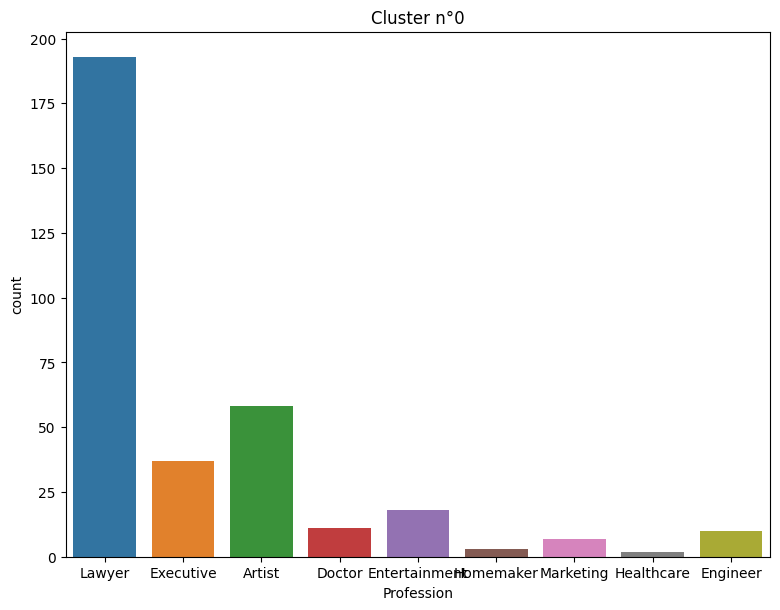

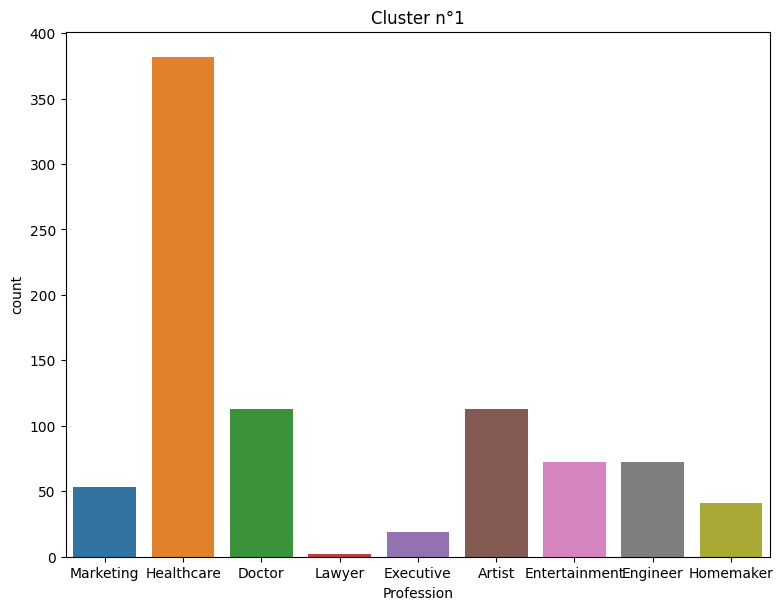

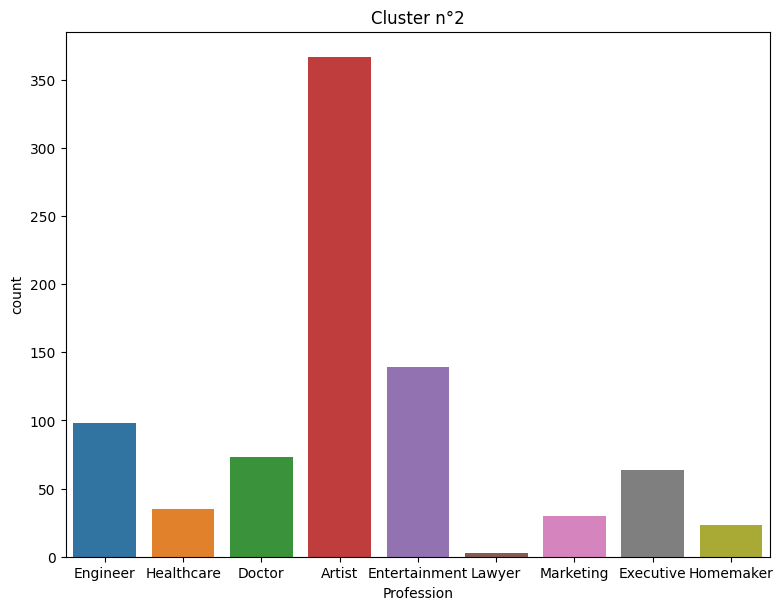

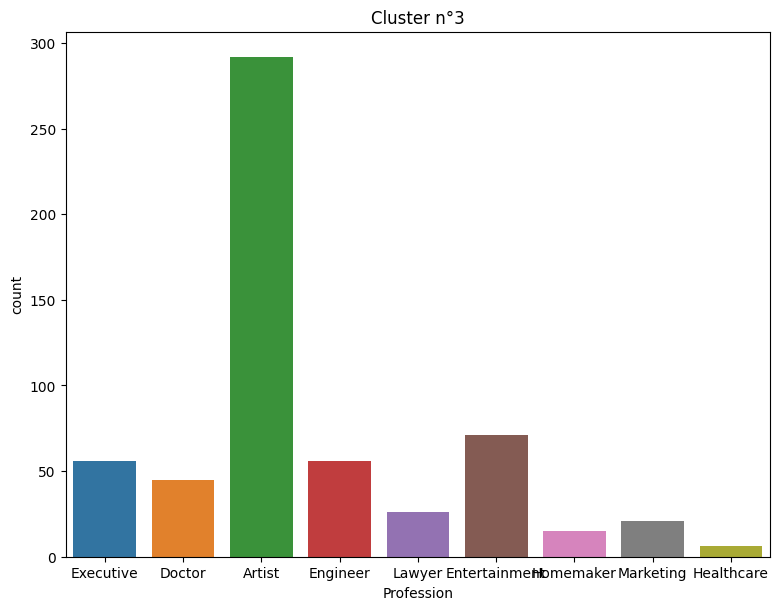

In [168]:
for i in [0,1,2,3]:
    plt.figure(figsize=(20,15))
    plt.subplot(2,2,i+1)
    plt.title("Cluster n°"+str(i))
    df.query("cluster=="+str(i))
    sns.countplot(df.query("cluster=="+str(i)),x="Profession")

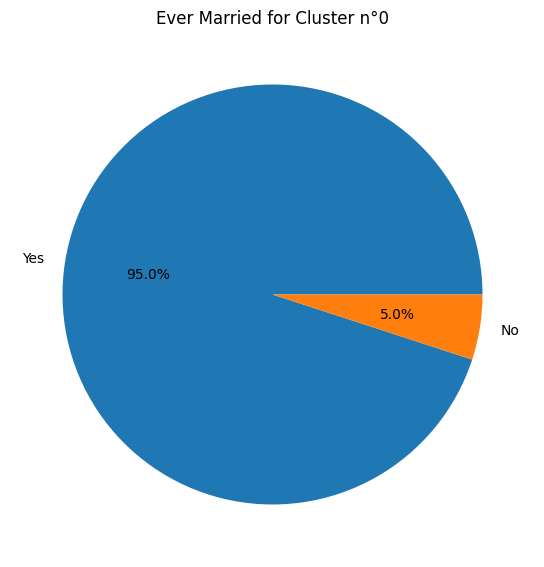

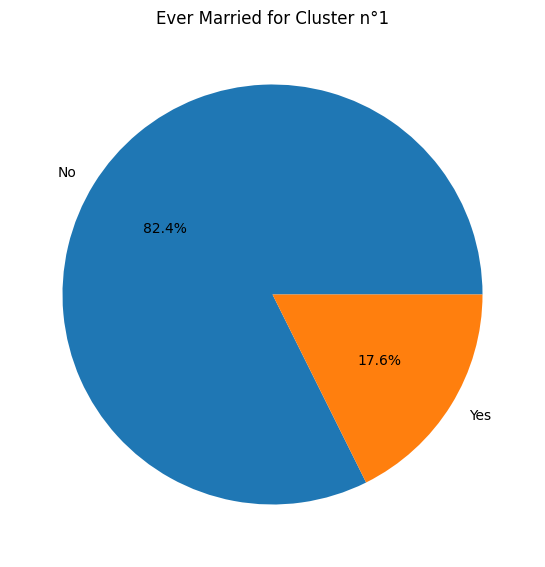

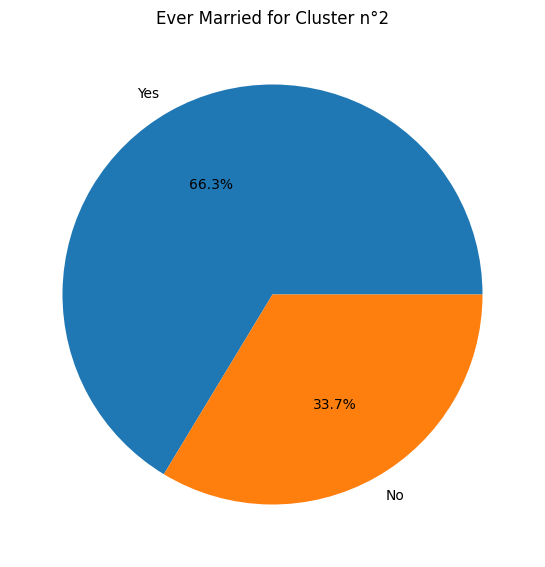

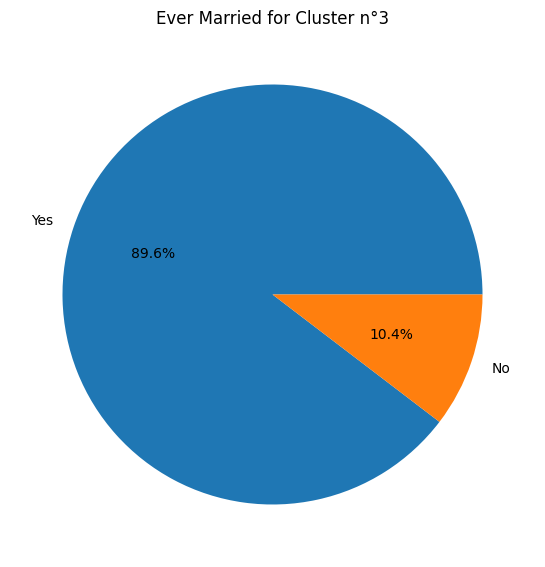

In [169]:
for i in [0,1,2,3]:
    plt.figure(figsize=(20,15))
    plt.subplot(2,2,i+1)
    data = df.query("cluster=="+str(i)).Ever_Married.value_counts()


    plt.pie(data, labels=data.index, autopct='%1.1f%%')
    plt.title('Ever Married for Cluster n°'+str(i))
    plt.show()

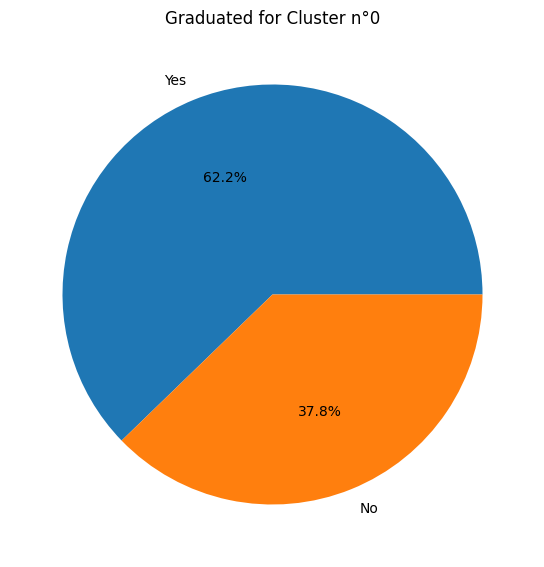

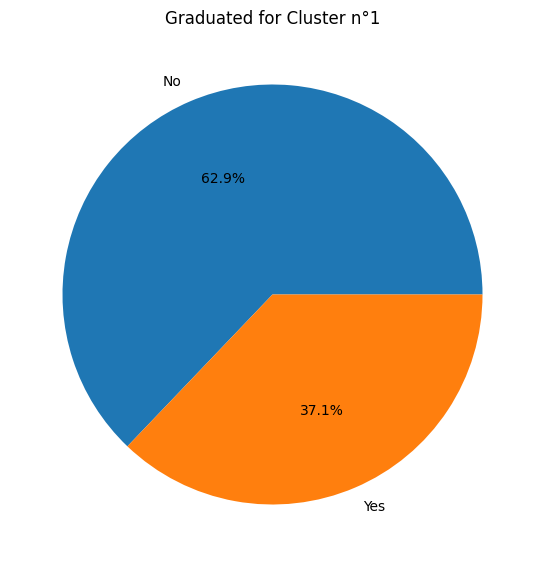

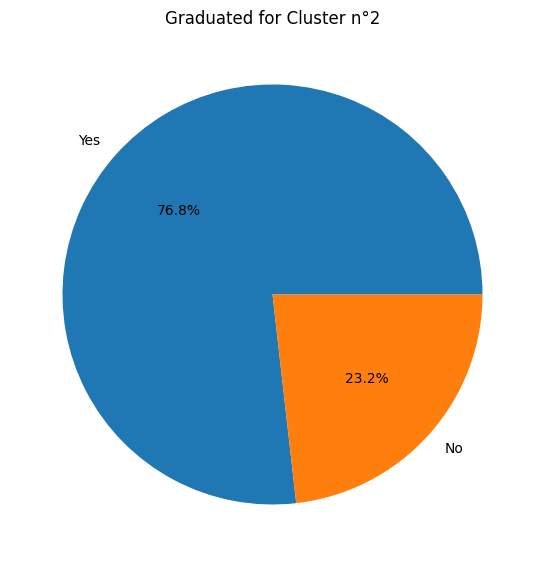

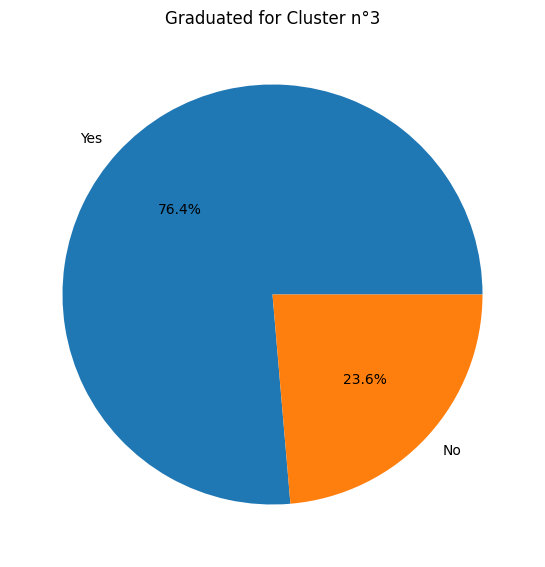

In [170]:
for i in [0,1,2,3]:
    plt.figure(figsize=(20,15))
    plt.subplot(2,2,i+1)
    data = df.query("cluster=="+str(i)).Graduated.value_counts()


    plt.pie(data, labels=data.index, autopct='%1.1f%%')
    plt.title('Graduated for Cluster n°'+str(i))
    plt.show()

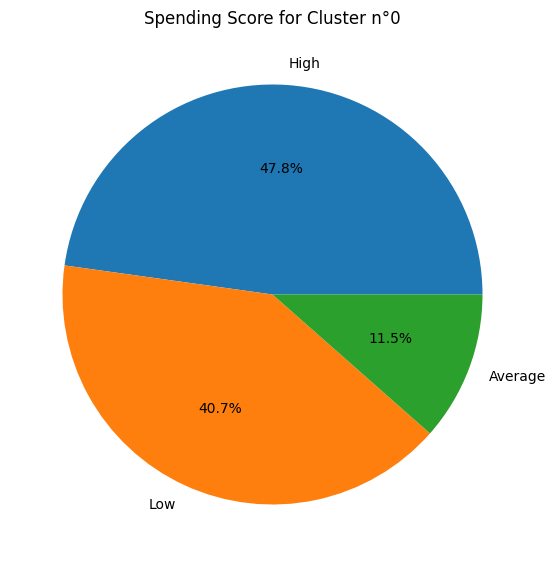

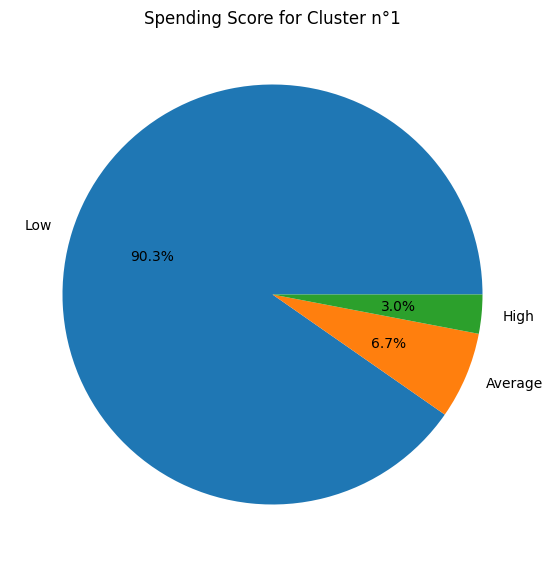

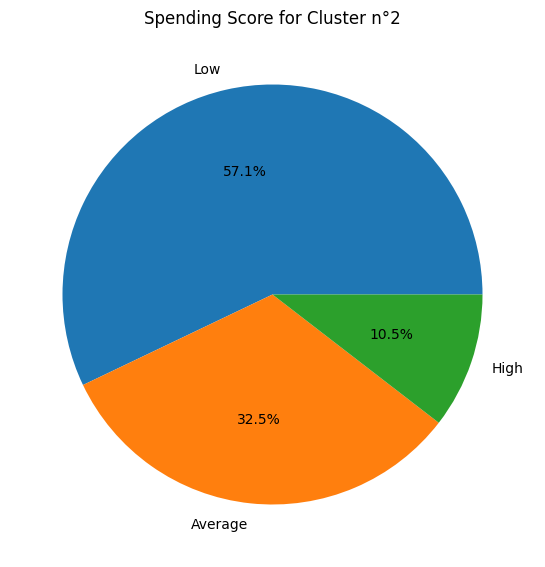

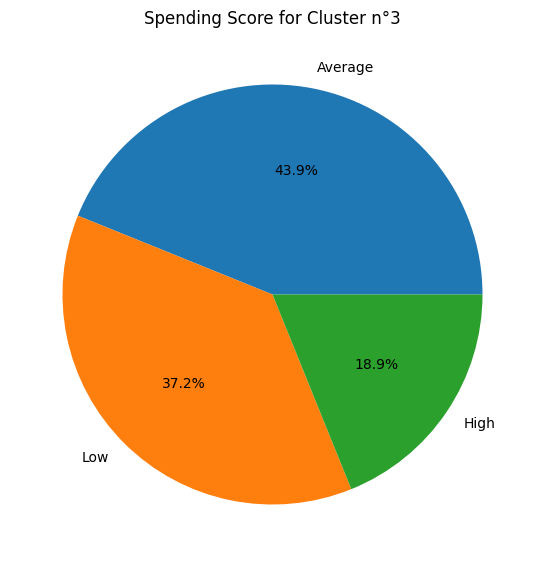

In [171]:
for i in [0,1,2,3]:
    plt.figure(figsize=(20,15))
    plt.subplot(2,2,i+1)
    data = df.query("cluster=="+str(i)).Spending_Score.value_counts()


    plt.pie(data, labels=data.index, autopct='%1.1f%%')
    plt.title('Spending Score for Cluster n°'+str(i))
    plt.show()

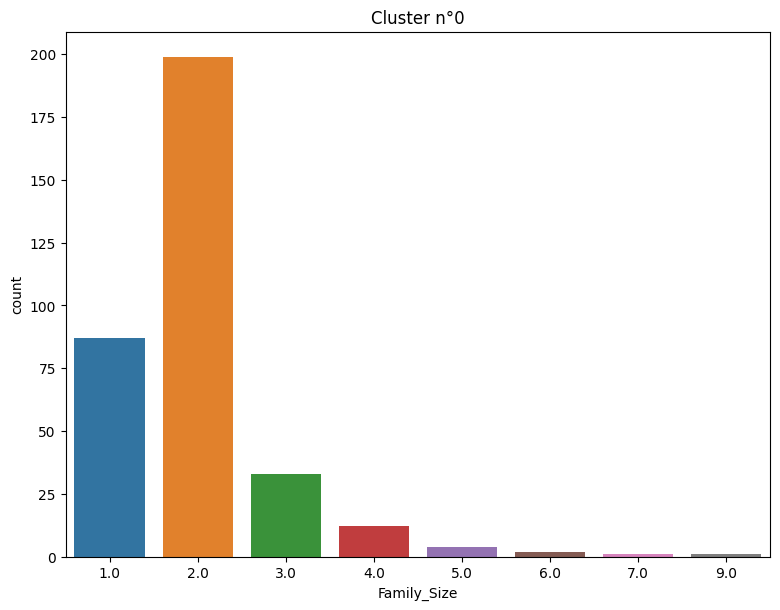

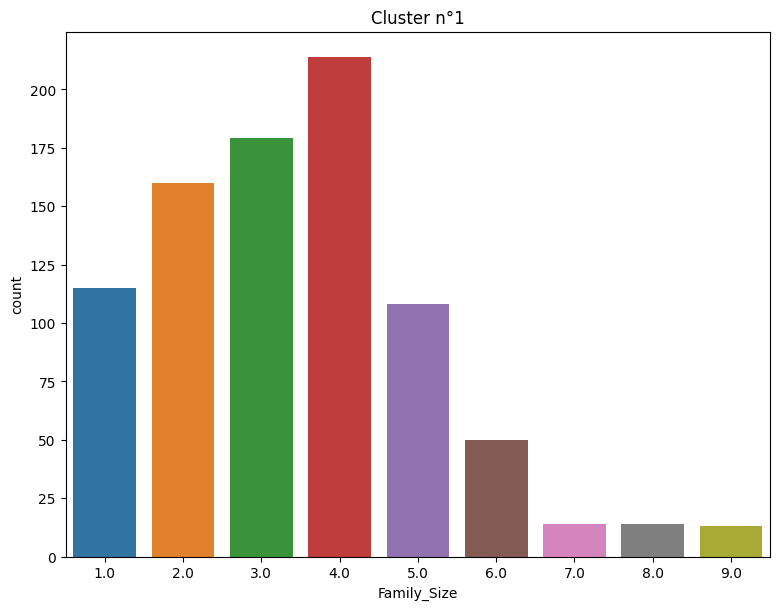

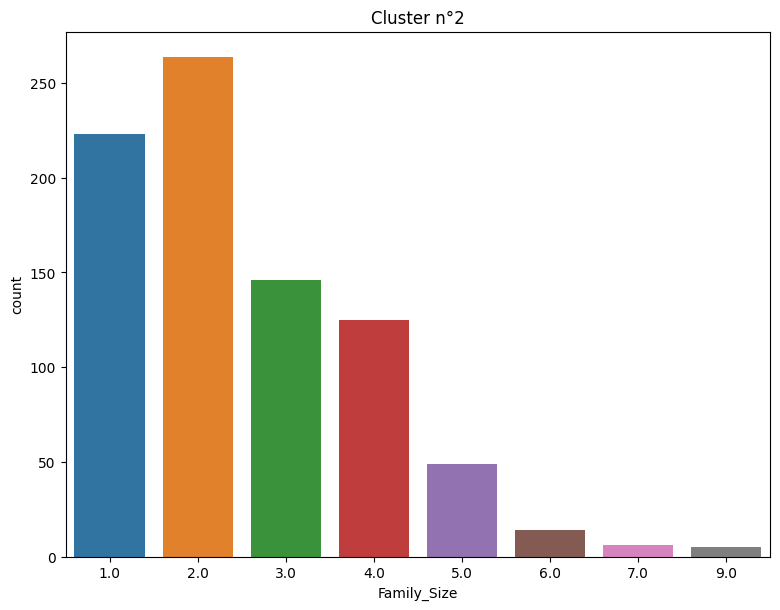

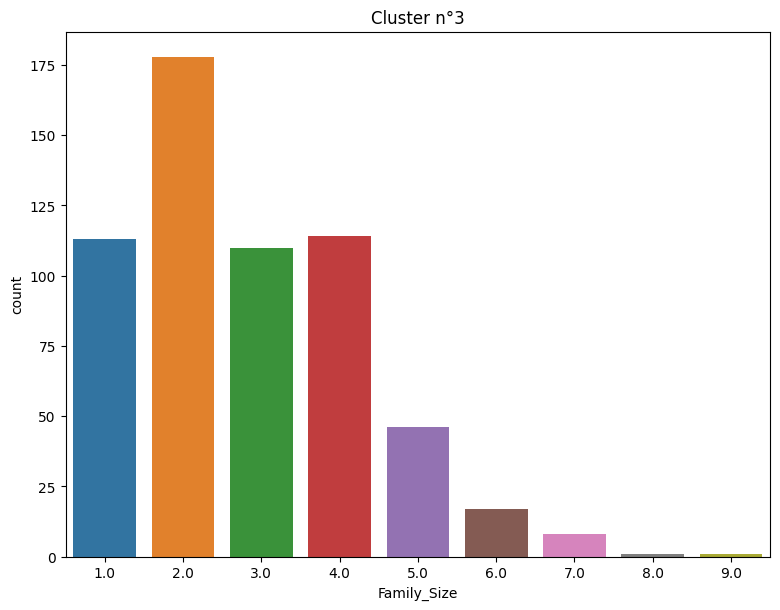

In [172]:
for i in [0,1,2,3]:
    plt.figure(figsize=(20,15))
    plt.subplot(2,2,i+1)
    plt.title("Cluster n°"+str(i))
    df.query("cluster=="+str(i))
    sns.countplot(df.query("cluster=="+str(i)),x="Family_Size")

In [173]:
print(df[['cluster','Age']].groupby(by=['cluster']).mean())

               Age
cluster           
0        75.961652
1        26.395617
2        40.580529
3        54.812925


### Summary of Clusters' features

#### Cluster 0
<u>Jobs :</u> Mostly Artist - Entertainment - Engineer

<u>Married ? :</u> Yes 66 % / No 34 % 

<u>Graduated ? :</u> Yes 76 % / No 24 % 

<u>Spending Score :</u>  Low 55% / Average 34 % / High 11 % 

<u>Family Size :</u> Mostly 2 / Sometimes 1 / Sometimes 3  

<u>Average Age :</u> 40

<u>Description :</u>

Cluster 0 is characterized by customers who are mostly in the artistic, entertainment and engineering fields, have a low and average spending score, and are mostly married and graduated, with an average age of 40. 

They are likely to be budget-conscious shoppers but also willing to spend on average priced items. They are likely to have a family and are in the prime of their career, likely to have a balance between work and personal life.


#### Cluster 1
<u>Jobs :</u> Mostly Healthcare - Doctor - Artist

<u>Married ? :</u> Yes 18 % / No 82 % 

<u>Graduated ? :</u> Yes 37 % / No 63 % 

<u>Spending Score :</u>  Low 88% / Average 8 % / High 4 % 

<u>Family Size :</u> Mostly 4 or 3 or 2   

<u>Average Age :</u> 26

<u>Description :</u>

Cluster 1 is characterized by customers who are mostly in the healthcare and artistic fields, have a low spending score, and are mostly not married and not graduated, with a young average age.

They are mostly budget-conscious shoppers and have a higher chance to be family-oriented.


#### Cluster 2
<u>Jobs :</u> Mostly Lawyer - Artist - Execution

<u>Married ? :</u> Yes 95 % / No 5 % 

<u>Graduated ? :</u> Yes 63 % / No 37 % 

<u>Spending Score :</u>  Low 41% / Average 13 % / High 46 % 

<u>Family Size :</u> Mostly 2 / Sometimes 1 / Sometimes 3  

<u>Average Age :</u> 74

<u>Description :</u>

Cluster 2 is characterized by customers who are mostly in the legal and artistic fields, have a low spending score, and are mostly married and graduated, with an older average age (74).

They are mostly budget-conscious shoppers but are more likely to be single. But it also includes a high number of customers with High Spending score.


#### Cluster 3
<u>Jobs :</u> Mostly Artist - Entertainment - Execution

<u>Married ? :</u> Yes 88 % / No 12 % 

<u>Graduated ? :</u> Yes 80 % / No 20 % 

<u>Spending Score :</u>  Low 38% / Average 44 % / High 18 % 

<u>Family Size :</u> Mostly 2 / Sometimes 3 / Sometimes 4  

<u>Average Age :</u> 54

<u>Description :</u>

Cluster 3 is characterized by customers who are mostly in the artistic and executive fields, have a low spending score, and are mostly married and graduated, with an average age of 54.

Cluster 3 has a higher number of customers with average spending score.

## Conclusion

#### I hope you liked this analysis, of course, I surely missed several things and I would be delighted to have your opinions and suggestions on my work! A like would be nice too <3